In [1]:
import cartopy
import matplotlib as mpl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
mpl.rcParams.update({'font.size': 16})

## This notebook plots the 4 figures in Pouplin et al. 2021 (submitted manuscript)

## 1. Load data

In [3]:
# Replace path_to_data by your path
path_to_data = '/export/home/cpouplin/Data/Data_paper_Larry/'
ds_life_cycle = xr.open_dataset(f'{path_to_data}/Larry_life_cycle.nc')
ds_obs = xr.open_dataset(f'{path_to_data}/Larry_observations_and_propagation.nc')

## 2. Functions

In [4]:
def get_extent_TC_swell(TC_track):
    """
    Depending on the basin, provides the corresponding map extent

    INPUT:
    TC_track: TCTrack object

    OUTPUT:
    ext: map extent corresponding to this tropical cyclone
    cen: Basically 0 for Atlantic and Indian oceans, or 180 degrees for Pacific
    ocean
    """

    basin = np.unique(TC_track.basin[0])
    if basin == b'NA':
        ext = (-90, 0, 0, 70)
        cen = 0
    if basin == b'SA':
        ext = (-60, 20, -70, 10)
        cen = 0
    if (basin == b'NI') or (basin == b'SI'):
        ext = (30, 120, -65, 25)
        cen = 0
    if basin == b'EP':
        ext = (170, 270, -30, 60)
        cen = 180
    if basin == b'SP':
        ext = (140, 260, -70, 30)
        cen = 180
    if (basin == b'WP') or (basin == b''):
        ext = (120, 220, -30, 60)
        cen = 180
    return(ext, cen)

def plot_track_parameters(TC,
                          plot_Lcr=False,
                          savepath=None,
                          horizontal=True,
                          axs=None,
                          date_sel=None,
                          date_sel2=np.datetime64('2021-09-03 12:00:00'),
                          date_sel3=np.datetime64('2021-09-05 06:00:00'),
                          date_sel4=np.datetime64('2021-09-06 21:00:00'),
                          add_map=True,
                          add_lbda_stat=False,
                          add_lbda_min_and_max=False,
                          add_aspect_ratio=False,
                          add_radii_ratio=False,
                          plot_annotation_for_Larry=False,
                          el=True,
                          Rmax_type='ibtracs',
                          figure=None,
                          wave_rose=None,
                          date_min=None,
                          date_max=None,
                          figsize=(20, 30),
                          **kwargs):
    """
    -> Plots a graph of the evolution of the main TC parameters:
    Vmax, Rmax, translation speed, and critical fetch
    -> Plots a map with TC trajectory and daily evolution of wind radii
    """

    if el:
        large_ax_var = 'L_el'
        exc_var = 'e_el'
        mean_wavelength_var = 'mean_wavelength_el'
        data_reliability_var = 'data_reliability_el'
        phi0_var = 'phi0_el'
        asym_factor_var = 'asym_factor_el'
        aspect_ratio_var = 'aspect_ratio_el'
    else:
        large_ax_var = 'a0_ai'
        exc_var = 'a1_ai'
        mean_wavelength_var = 'mean_wavelength_ai'
        data_reliability_var = 'data_reliability_ai'
        phi0_var = 'phi0_ai'
        asym_factor_var = 'asym_factor_ai'
        aspect_ratio_var = 'aspect_ratio_ai'
    if date_min == None:
        date_min = TC.time.min().values
    if date_max == None:
        date_max = TC.time.max().values
    if figure is None:
        fig = plt.figure(figsize=figsize, facecolor='w', **kwargs)
        #fig.suptitle(f"TC tracks for TC {TC.name}, {TC.atcf_id}, starting on {str(TC.time.values[0])[:10]} at {str(TC.time.values[0])[11:13]}:00")
        gs = GridSpec(6, 3, width_ratios=[4, 0.0, 0.1], height_ratios=[2, 0.8, 0.4, 0.4, 0.4, 0.4])
        if add_map and wave_rose is None:
            gs = GridSpec(2, 3, width_ratios=[4, 0.0, 0.1], height_ratios=[2, 0.8])
        if not add_map and wave_rose is not None:
            gs = GridSpec(5, 3, width_ratios=[4, 0.0, 0.1], height_ratios=[0, 0.6, 0.4, 0.4, 0.4])
    else:
        fig = figure
    ext, cen = get_extent_TC_swell(TC)
    if axs is not None:
        ax0 = axs[0]
        ax1 = axs[1]
    else:
        ax0 = fig.add_subplot(gs[1, 0])
        if add_map:
            ax1 = fig.add_subplot(gs[0, 0], projection=cartopy.crs.PlateCarree(central_longitude=cen))
            cb_ax = fig.add_subplot(gs[0, 2])
        if wave_rose is not None:
            ax2 = fig.add_subplot(gs[2, 0])
            cb_ax2 = fig.add_subplot(gs[2:, 2])
            ax3 = fig.add_subplot(gs[3, 0])
            #cb_ax3 = fig.add_subplot(gs[3, 2])
            ax4 = fig.add_subplot(gs[4, 0])
            #cb_ax4 = fig.add_subplot(gs[4, 2])
            if add_aspect_ratio or add_radii_ratio:
                ax5 = fig.add_subplot(gs[5, 0])
                #cb_ax5 = fig.add_subplot(gs[5, 2])
    #ax0.set_xlabel(f"Time in days since {str(TC.time.isel(date=0).values)[:19]}")
    # TC parameters

    ax0.grid()
    ax0_bis = ax0.twinx()
    ax0_ter = ax0.twinx()
    ax0_quad = ax0.twinx()
    ax0_ter.spines["right"].set_position(("axes", 1.08))
    ax0_quad.spines["right"].set_position(("axes", -0.15))
    (p_vmax,) = ax0.plot(TC.time, TC.vmax, color="b")
    (p_tr_speed,) = ax0_bis.plot(
        TC.time, TC.translation_speed, color="g"
    )
    (p_Rmax,) = ax0_ter.plot(TC.time, TC.Rmax, color="r")
    (p_R34,) = ax0_quad.plot(TC.time, TC.R34, color="k")

    ax0.set_ylabel("Maximum wind\nspeed (m/s)", color="b")
    ax0_bis.set_ylabel("Translation speed (m/s)", color="g")
    ax0_ter.set_ylabel("Maximum wind radius (km)", color="r")
    ax0_quad.set_ylabel("34 kts wind radius (km)", color="k")

    ax0.spines["left"].set_color(p_vmax.get_color())
    ax0_bis.spines["right"].set_color(p_tr_speed.get_color())
    ax0_ter.spines["right"].set_color(p_Rmax.get_color())
    ax0_quad.spines["right"].set_color(p_R34.get_color())

    ax0.yaxis.label.set_color(p_vmax.get_color())
    ax0_bis.yaxis.label.set_color(p_tr_speed.get_color())
    ax0_ter.yaxis.label.set_color(p_Rmax.get_color())
    ax0_quad.yaxis.label.set_color(p_R34.get_color())

    ax0.tick_params(axis="y", colors=p_vmax.get_color())
    ax0_bis.tick_params(axis="y", colors=p_tr_speed.get_color())
    ax0_ter.tick_params(axis="y", colors=p_Rmax.get_color())
    ax0_quad.tick_params(axis="y", colors=p_R34.get_color())
    ax0.set_xlim((date_min, date_max))

    if date_sel is not None:
        ax0.axvline(date_sel, c='k', linestyle='--')
        if wave_rose is not None:
            ax2.axvline(date_sel, c='k', linestyle='--')
            ax3.axvline(date_sel, c='k', linestyle='--')
            ax4.axvline(date_sel, c='k', linestyle='--')
            if add_aspect_ratio or add_radii_ratio:
                ax5.axvline(date_sel, c='k', linestyle='--')
    if date_sel2 is not None:
        ax0.axvline(date_sel2, c='orange', linestyle='--')
        if wave_rose is not None:
            ax2.axvline(date_sel2, c='orange', linestyle='--')
            ax3.axvline(date_sel2, c='orange', linestyle='--')
            ax4.axvline(date_sel2, c='orange', linestyle='--')
            if add_aspect_ratio or add_radii_ratio:
                ax5.axvline(date_sel2, c='orange', linestyle='--')
    if date_sel3 is not None:
        ax0.axvline(date_sel3, c='cyan', linestyle='--')
        if wave_rose is not None:
            ax2.axvline(date_sel3, c='cyan', linestyle='--')
            ax3.axvline(date_sel3, c='cyan', linestyle='--')
            ax4.axvline(date_sel3, c='cyan', linestyle='--')
            if add_aspect_ratio or add_radii_ratio:
                ax5.axvline(date_sel3, c='cyan', linestyle='--')
    if date_sel4 is not None:
        ax0.axvline(date_sel4, c='pink', linestyle='--')
        if wave_rose is not None:
            ax2.axvline(date_sel4, c='pink', linestyle='--')
            ax3.axvline(date_sel4, c='pink', linestyle='--')
            ax4.axvline(date_sel4, c='pink', linestyle='--')
            if add_aspect_ratio or add_radii_ratio:
                ax5.axvline(date_sel4, c='pink', linestyle='--')
    ax0.tick_params(axis="y", colors=p_vmax.get_color())
    ax0_bis.tick_params(axis="y", colors=p_tr_speed.get_color())
    ax0_ter.tick_params(axis="y", colors=p_Rmax.get_color())
    if plot_Lcr:
        ax0_quad = ax0.twinx()
        ax0_quad.spines["left"].set_position(("axes", -0.06))
        (p_Lcr, ) = ax0_quad.plot(TC.time, TC.Lcr, color="k")
        ax0_quad.set_ylim(0, 100)
        ax0_quad.set_ylabel("Critical fetch (km)", color="k")
        ax0_quad.spines["left"].set_color(p_Lcr.get_color())
        ax0_quad.yaxis.label.set_color(p_Lcr.get_color())
        ax0_quad.tick_params(axis="y", colors=p_Lcr.get_color())

    if wave_rose is not None:
        g = 9.81
        q = - 0.27
        ca = 11.5
        if add_lbda_stat:
            lbda_stat_max = (2 * np.pi * (wave_rose.vmax ** 2) / g) * (ca ** (-2)) * (wave_rose.Rmax * 1000 * g / (wave_rose.vmax ** 2)) ** (-2 * q)
            lbda_stat_R34 = (2 * np.pi * (17.49111111 ** 2) / g) * (ca ** (-2)) * (wave_rose.R34 * 1000 * g / (17.49111111 ** 2)) ** (-2 * q)
            lbda_stat_R50 = (2 * np.pi * (25.7222 ** 2) / g) * (ca ** (-2)) * (wave_rose.R50 * 1000 * g / (25.7222 ** 2)) ** (-2 * q)
            lbda_stat_R64 = (2 * np.pi * (32.9244 ** 2) / g) * (ca ** (-2)) * (wave_rose.R64 * 1000 * g / (32.9244 ** 2)) ** (-2 * q)
            #lbda_stat_all = xr.concat((lbda_stat_max, lbda_stat_R34, lbda_stat_R50, lbda_stat_R60), dim='type').max('type')
            scat_2_stat = ax2.plot(TC.time, lbda_stat_max, c='purple', label='Hypothetical stationnary TC at Rmax')
            scat_2_stat = ax2.plot(TC.time, lbda_stat_R34, c='green', label='Hypothetical stationnary TC at R34')
            #scat_2_stat = ax2.plot(TC.time, lbda_stat_R50, c='orange', label='Hyp. stat. TC at R50')
            #scat_2_stat = ax2.plot(TC.time, lbda_stat_R64, c='red', label='Hyp. stat. TC at R64')
        if add_lbda_min_and_max:
            scat_min = ax2.scatter(wave_rose.time, wave_rose[large_ax_var] - wave_rose[exc_var], c='k', marker='v', s=80, label='Observed shortest wavelength')
            scat_max = ax2.scatter(wave_rose.time, wave_rose[large_ax_var] + wave_rose[exc_var], c='k', marker='^', s=80, label='Observed longest wavelength')
        scat_2 = ax2.scatter(wave_rose.time, wave_rose[mean_wavelength_var], c=wave_rose[data_reliability_var], cmap='hot', edgecolor='k', s=80, label='Observed mean wavelength')
        ax2.grid()
        ax2.legend(fontsize=9)
        ax2.set_xlim((date_min, date_max))
        ax2.set_ylim((0, 450))
        ax2.set_ylabel("Observed wavelength")
        plt.colorbar(scat_2, label="Reliability", cax=cb_ax2)
        scat_3 = ax3.scatter(wave_rose.time, wave_rose[phi0_var], c=wave_rose[data_reliability_var], cmap='hot', edgecolor='k', s=80)
        ax3.grid()
        ax3.set_xlim((date_min, date_max))
        ax3.set_ylim((-80, 50))
        ax3.set_ylabel("Orientation (phi_0)")
        #plt.colorbar(scat_3, label="Reliability", cax=cb_ax3)
        scat_4 = ax4.scatter(wave_rose.time, wave_rose[asym_factor_var], c=wave_rose[data_reliability_var], cmap='hot', edgecolor='k', s=80)
        ax4.grid()
        ax4.set_xlim((date_min, date_max))
        ax4.set_ylim((0, 4))
        ax4.set_ylabel("Front - rear\nasymetry factor")
        #plt.colorbar(scat_4, label="Reliability", cax=cb_ax4)
        if add_aspect_ratio:
            scat_5 = ax5.scatter(wave_rose.time, wave_rose[aspect_ratio_var], c=wave_rose[data_reliability_var], cmap='hot', edgecolor='k', s=80)
            ax5.grid()
            ax5.set_xlim((date_min, date_max))
            ax5.set_ylim((0.7, 1.05))
            ax5.set_ylabel("Aspect ratio")
            plt.colorbar(scat_5, label="Reliability", cax=cb_ax5)
        if add_radii_ratio:
            alpha_w = 0
            #r_eff = (wave_rose.vmax ** 2 / g) * ((ca ** 2 * wave_rose.mean_wavelength_el * g) / (2 * np.pi * wave_rose.vmax ** 2)) ** (- 1 / (2 * q))
            r_eff = ((wave_rose[mean_wavelength_var] * np.sqrt(g) * (ca ** 2)) / (2 * np.pi * wave_rose.vmax * (1000 * wave_rose.Rmax) ** alpha_w)) ** (1 / (0.5 - alpha_w))
            print(r_eff)
            scat_5 = ax5.scatter(wave_rose.time, r_eff / 1000 / wave_rose.Rmax, c=wave_rose[data_reliability_var], cmap='hot', edgecolor='k', s=80)
            ax5.set_ylim((0, 4))
            ax5.grid()
            ax5.set_xlim((date_min, date_max))
            ax5.set_ylabel("Radii ratio")
            plt.colorbar(scat_5, label="Reliability", cax=cb_ax5)

    if plot_annotation_for_Larry:
        ax0.fill_between([np.datetime64('2021-09-01'), np.datetime64('2021-09-04')],
                         [100, 100],
                         color='g',
                         alpha=0.1,
                         label='Intensification phase')
        ax0.fill_between([np.datetime64('2021-09-04'), np.datetime64('2021-09-08')],
                         [100, 100],
                         color='orange',
                         alpha=0.1,
                         label='Mature phase')
        ax0.fill_between([np.datetime64('2021-09-08'), np.datetime64('2021-09-12')],
                         [100, 100],
                         color='r',
                         alpha=0.1,
                         label='Decreasing phase')
        if wave_rose is not None:
            ax2.fill_between([np.datetime64('2021-09-01'), np.datetime64('2021-09-04')],
                             [450, 450],
                             color='g',
                             alpha=0.1)
            ax2.fill_between([np.datetime64('2021-09-04'), np.datetime64('2021-09-08')],
                             [450, 450],
                             color='orange',
                             alpha=0.1)
            ax2.fill_between([np.datetime64('2021-09-08'), np.datetime64('2021-09-12')],
                             [450, 450],
                             color='r',
                             alpha=0.1)
            ax3.fill_between([np.datetime64('2021-09-01'), np.datetime64('2021-09-04')],
                             [100, 100],
                             y2=[-100, -100],
                             color='g',
                             alpha=0.1)
            ax3.fill_between([np.datetime64('2021-09-04'), np.datetime64('2021-09-08')],
                             [100, 100],
                             y2=[-100, -100],
                             color='orange',
                             alpha=0.1)
            ax3.fill_between([np.datetime64('2021-09-08'), np.datetime64('2021-09-12')],
                             [100, 100],
                             y2=[-100, -100],
                             color='r',
                             alpha=0.1)
            ax4.fill_between([np.datetime64('2021-09-01'), np.datetime64('2021-09-04')],
                             [400, 400],
                             color='g',
                             alpha=0.1)
            ax4.fill_between([np.datetime64('2021-09-04'), np.datetime64('2021-09-08')],
                             [400, 400],
                             color='orange',
                             alpha=0.1)
            ax4.fill_between([np.datetime64('2021-09-08'), np.datetime64('2021-09-12')],
                             [400, 400],
                             color='r',
                             alpha=0.1)
            if add_aspect_ratio or add_radii_ratio:
                ax5.fill_between([np.datetime64('2021-09-01'), np.datetime64('2021-09-04')],
                                 [400, 400],
                                 color='g',
                                 alpha=0.1)
                ax5.fill_between([np.datetime64('2021-09-04'), np.datetime64('2021-09-08')],
                                 [400, 400],
                                 color='orange',
                                 alpha=0.1)
                ax5.fill_between([np.datetime64('2021-09-08'), np.datetime64('2021-09-12')],
                                 [400, 400],
                                 color='r',
                                 alpha=0.1)
        ax0.set_ylim((0, 70))
        ax0.legend(loc=2, fontsize=14)
        #ax0 = double_arrow_annotation(ax0, 'Step 1: Intensification phase', np.datetime64('2021-09-01'), np.datetime64('2021-09-04'), 0, 100, size=18)
        #ax0 = double_arrow_annotation(ax0, 'Step 2: Mature phase', np.datetime64('2021-09-04'), np.datetime64('2021-09-08'), 0, 100, size=18)
        #ax0 = double_arrow_annotation(ax0, 'Step 3: Decreasing phase', np.datetime64('2021-09-08'), np.datetime64('2021-09-12'), 0, 100, size=18)

        #ax0.axvline(np.datetime64('2021-09-07 06:00:00'), c='k', linestyle='--')
        #ax0.annotate("Selected date 1", (np.datetime64('2021-09-03 09:00:00'), 2), c='purple', ha='center')
        #ax0.annotate("Selected date 2", (np.datetime64('2021-09-07 06:00:00'), 2), c='purple', ha='center')
    if add_map:
        ax1.coastlines(resolution='50m')
        ax1.gridlines(draw_labels=True)
        ax1.set_extent(ext)
        ax1.stock_img()


        # Prepare wind radii drawing Coordinates
        resolution = 1
        proj = cartopy.crs.PlateCarree()
        azimuth = np.arange(0,361,resolution)
        if 'r34_ne' in list(TC.keys()):
            R34s = np.repeat(np.stack([TC.r34_ne, TC.r34_se, TC.r34_sw, TC.r34_nw]).T, int(90/resolution), axis = 1)
            R34s = np.concatenate((R34s, np.array([TC.r34_ne]).T), axis=1)
            lon_R34, lat_R34 = rb2ll(R34s, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        else:
            lon_R34, lat_R34 = rb2ll(np.tile(TC.R34, (int(1 + 360/resolution),1)).T, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        if 'r50_ne' in list(TC.keys()):
            R50s = np.repeat(np.stack([TC.r50_ne, TC.r50_se, TC.r50_sw, TC.r50_nw]).T, int(90/resolution), axis = 1)
            R50s = np.concatenate((R50s, np.array([TC.r50_ne]).T), axis=1)
            lon_R50, lat_R50 = rb2ll(R50s, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        else:
            lon_R50, lat_R50 = rb2ll(np.tile(TC.R50, (int(1 + 360/resolution),1)).T, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        if 'r64_ne' in list(TC.keys()):
            R64s = np.repeat(np.stack([TC.r64_ne, TC.r64_se, TC.r64_sw, TC.r64_nw]).T, int(90/resolution), axis = 1)
            R64s = np.concatenate((R64s, np.array([TC.r64_ne]).T), axis=1)
            lon_R64, lat_R64 = rb2ll(R64s, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        else:
            lon_R64, lat_R64 = rb2ll(np.tile(TC.R64, (int(1 + 360/resolution),1)).T, azimuth, np.tile(TC.lon,(int(1 + 360/resolution),1)).T, np.tile(TC.lat, (int(1 + 360/resolution),1)).T)
        Rmaxs = np.tile(TC.Rmax, (int(1 + 360/resolution), 1)).T
        lon_Rmax, lat_Rmax = rb2ll(Rmaxs, azimuth, np.tile(TC.lon,(1 + int(360/resolution),1)).T, np.tile(TC.lat, (1 + int(360/resolution),1)).T)
        scat_TC = ax1.scatter(TC.lon, TC.lat, marker='*', s=80, c=TC.days_since_start, cmap='jet', vmin=0, label=f'Track of TC Larry', transform=proj)
        plt.colorbar(scat_TC, label=f"Time in days since {str(TC.time.isel(time=0).values)[:19]}", cax=cb_ax)
        first_pass = True
        for i in range(0, TC.sizes['time']):
            if str(TC.time.isel(time=i).values)[12] == '0':#and str(TC.time.isel(date=i).values)[9] == '7':
                if first_pass:
                    first_pass = False
                    ax1.annotate(str(TC.time.isel(time=i).values)[0:10], (TC.lon.isel(time=i).values + 1, TC.lat.isel(time=i).values + 1), fontsize=16, rotation=20, ha='left')
                    lineR34 = ax1.plot(lon_R34.T[:, i], lat_R34.T[:, i], transform=proj, c='y', label='R34', **kwargs)
                    lineR50 = ax1.plot(lon_R50.T[:, i], lat_R50.T[:, i], transform=proj, c='orange', label='R50', **kwargs)
                    lineR64 = ax1.plot(lon_R64.T[:, i], lat_R64.T[:, i], transform=proj, c='r', label='R64', **kwargs)
                    lineRmax = ax1.plot(lon_Rmax.T[:, i], lat_Rmax.T[:, i], transform=proj, c='b', label='Rmax', **kwargs)
                ax1.annotate(str(TC.time.isel(time=i).values)[0:10], (TC.lon.isel(time=i).values + 1, TC.lat.isel(time=i).values + 1), fontsize=16, rotation=20, ha='left')
                lineR34 = ax1.plot(lon_R34.T[:, i], lat_R34.T[:, i], transform=proj, c='y', **kwargs)
                lineR50 = ax1.plot(lon_R50.T[:, i], lat_R50.T[:, i], transform=proj, c='orange', **kwargs)
                lineR64 = ax1.plot(lon_R64.T[:, i], lat_R64.T[:, i], transform=proj, c='r', **kwargs)
                lineRmax = ax1.plot(lon_Rmax.T[:, i], lat_Rmax.T[:, i], transform=proj, c='b', **kwargs)
        if date_sel is not None:
            ax1.scatter(TC.lon.sel(time=date_sel), TC.lat.sel(time=date_sel), marker='*', s=360, c='k', label=f'Location of TC Larry on {str(date_sel)[0:13]}', transform=proj, zorder=20)
        ax1.legend()
    if figure is not None:
        return(figure, ax0, ax1)
    if savepath is not None:
        plt.savefig(savepath, dpi=200)
    plt.show()

def rb2ll(dis: np.ndarray,
          bearing: np.ndarray,
          lon1: np.ndarray,
          lat1: np.ndarray):
    EARTH_RADIUS = 6371
    """
    From range, bearing compute latitude, longitude .
    INPUTS:
    lon1, lat1: longitude, latitude of starting point (deg).
    dis: distance to point of interest in kilometers.
    bearing :azimuth to point of interest (degrees).

    OUTPUTS:
    lon2, lat: longitude, latitude of point of interest (deg).
    """

    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    bearing = np.deg2rad(bearing)
    dis = dis / EARTH_RADIUS
    inside_arcsin = (np.sin(lat1) * np.cos(dis)
            + np.cos(lat1) * np.sin(dis) * np.cos(bearing))
    inside_arcsin = inside_arcsin.clip(min=-1, max=1)
    lat2 = np.arcsin(inside_arcsin)
    lon2 = (lon1 + np.arctan2(np.sin(bearing) * np.sin(dis) * np.cos(lat1),
                              np.cos(dis) - np.sin(lat1) * np.sin(lat2)))

    lat2 = np.rad2deg(lat2)
    lon2 = np.rad2deg(lon2)

    return lon2, lat2
# Params for Lcr computations
q = - 0.25
c_alpha = 11.8

## 3. Figures

#### Figure 1
- Plot the trajectory of the TC on a map
- Plot the evolution of the TC vitals

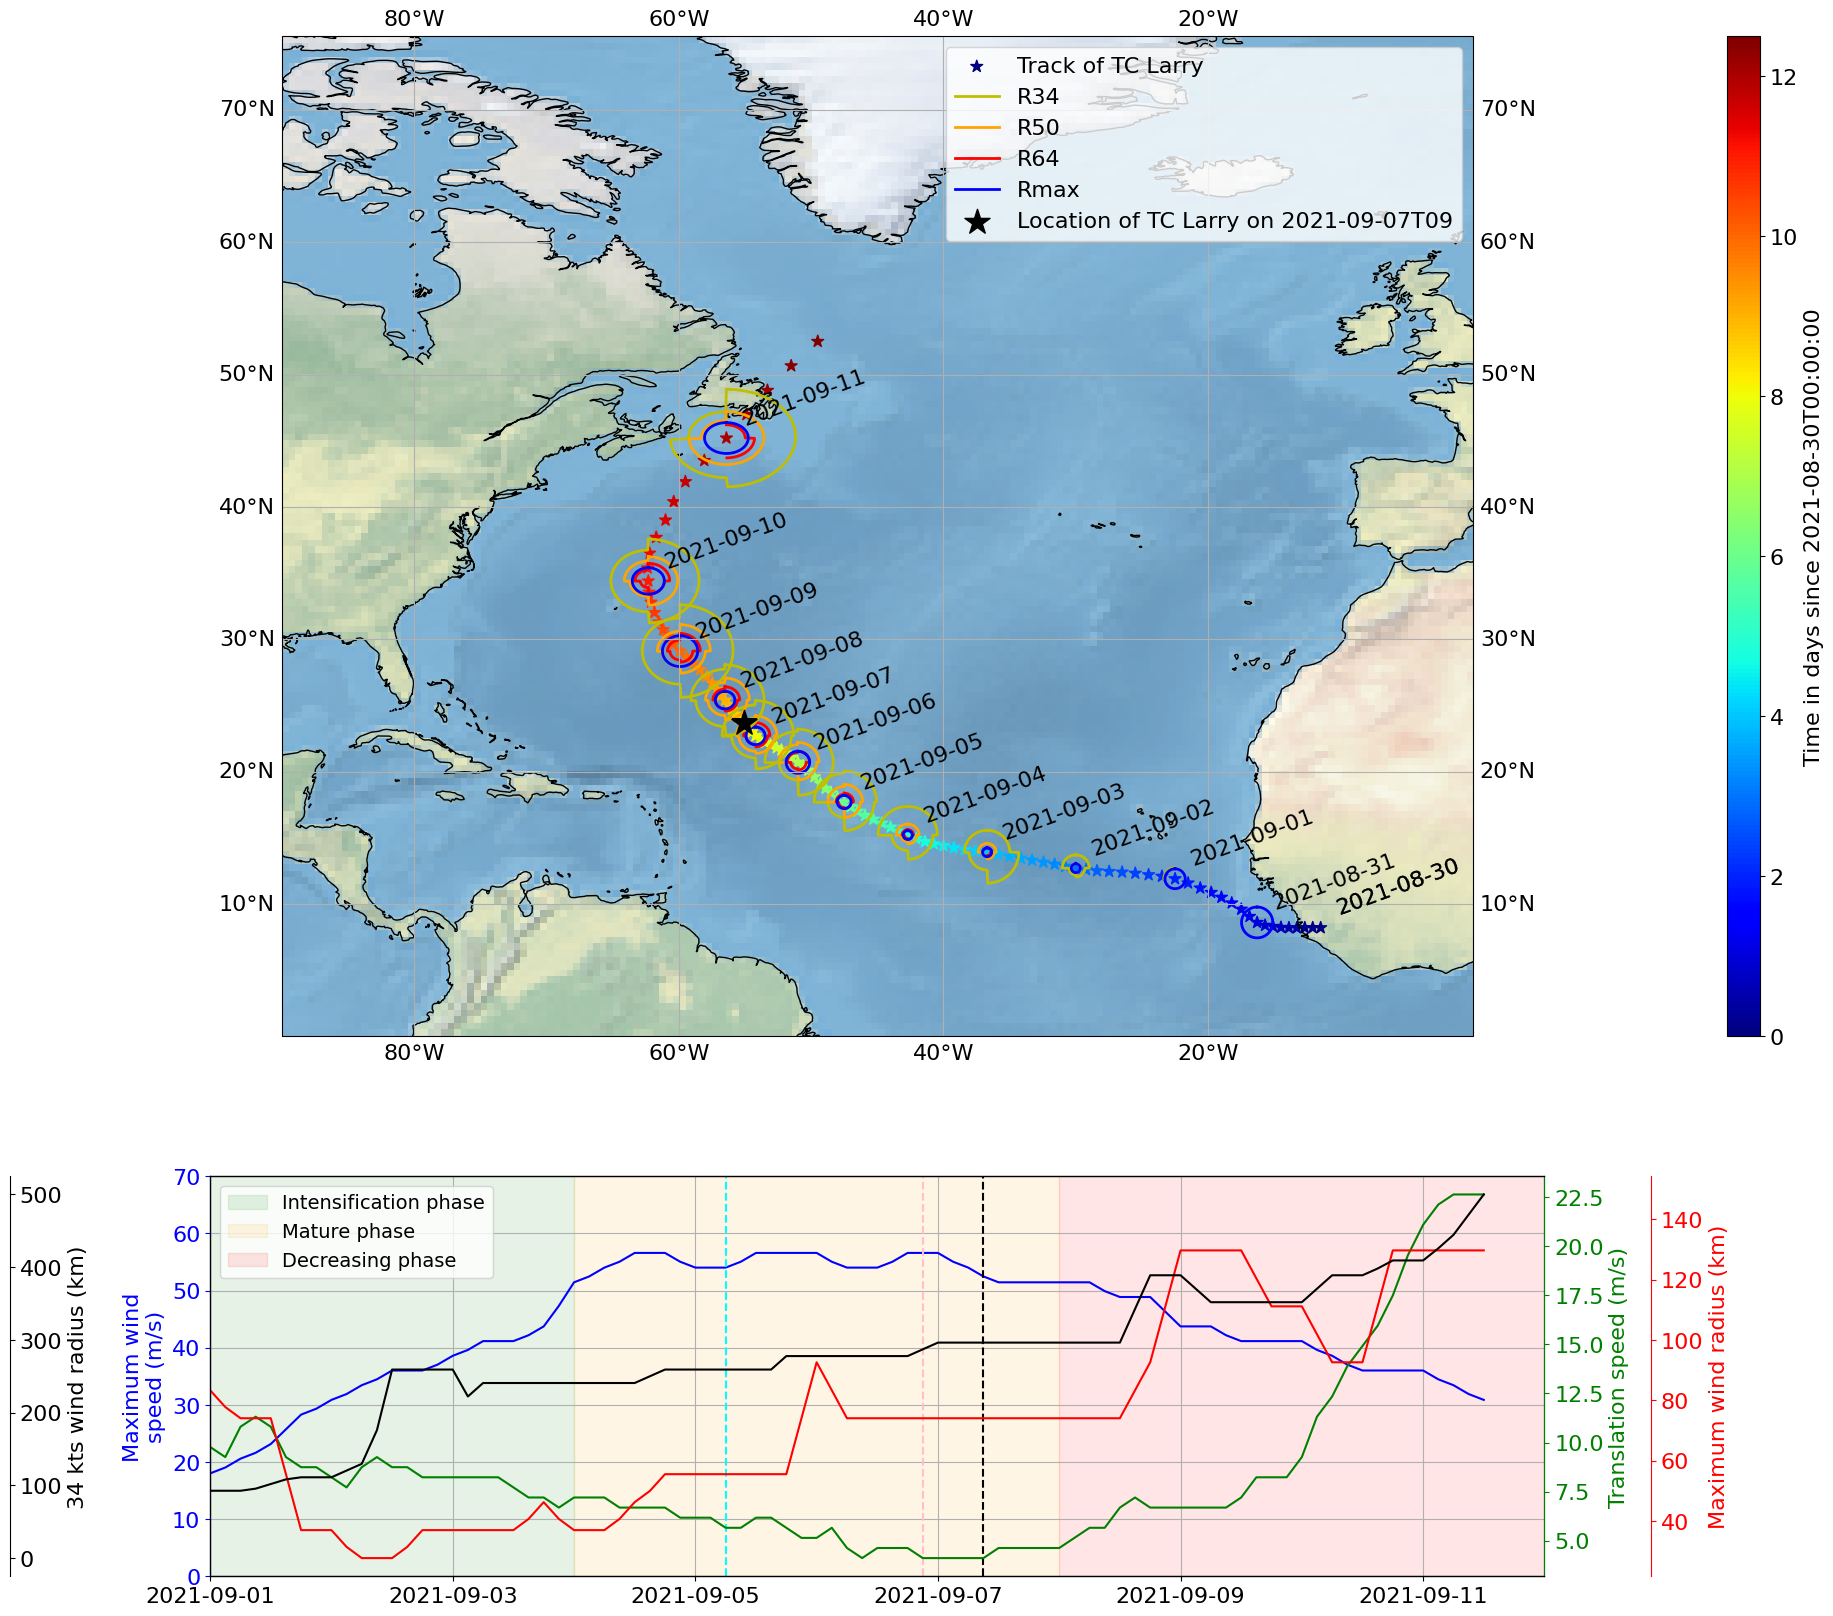

In [5]:
ds_life_cycle['days_since_start'] = (ds_life_cycle.time - ds_life_cycle.time.isel(time=0)) / np.timedelta64(1, 'D')
plot_track_parameters(ds_life_cycle, plot_Lcr=False, plot_annotation_for_Larry=True, linewidth=2, date_sel=np.datetime64('2021-09-07 09:00:00'), date_sel2=None, add_aspect_ratio=False, add_map=True, add_radii_ratio=False, add_lbda_min_and_max=False, add_lbda_stat=False, wave_rose=None, figsize=(20,20),date_min=np.datetime64('2021-09-01'), date_max=np.datetime64('2021-09-12 00:00:00'), savepath="/home1/datawork/cpouplin/Data/TC_Larry_map.png")
#plot_track_parameters(TC_1, plot_Lcr=False, plot_annotation_for_Larry=False, linewidth=2, date_sel=None, date_sel2=None, add_aspect_ratio=False, add_radii_ratio=True, wave_rose=ds_wave_roses)

#### Figure 2
- Draw the wave rose, with all sensors and for each specific sensor
- Draw back propagation trajectories on the map with the cyclone trajectory